# Exploratory Data Analysis

This notebook does exploratory data analysis and formats the data, like removing low-quality examples and converting columns to numeric format.

In [1]:
import sys
sys.path.append("../")

import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Reading in the dataset
df = pd.read_csv('../data/newsqa-data-v1.csv')
df.head()

,story_id,question,answer_char_ranges,is_answer_absent,is_question_bad,validated_answers
0,./cnn/stories/42d01e187213e86f5fe617fe32e716ff...,What was the amount of children murdered?,294:297|None|None,0.0,0.0,"{""none"": 1, ""294:297"": 2}"
1,./cnn/stories/c48228a52f26aca65c31fad273e66164...,Where was one employee killed?,34:60|1610:1618|34:60,0.0,0.0,NaN
2,./cnn/stories/c65ed85800e4535f4bbbfa2c34d7d963...,who did say South Africa did not issue a visa ...,103:127|114:127|839:853,0.0,0.0,"{""839:853"": 1, ""103:127"": 2}"
3,./cnn/stories/0cf66b646e9b32076513c050edf32a79...,How many years old was the businessman?,538:550|538:550,0.0,0.0,NaN
4,./cnn/stories/13012604e3203c18df09289dfedd14cd...,What frightened the families?,690:742|688:791|630:646,0.0,0.0,"{""688:791"": 2, ""690:742"": 1}"


In [3]:
# Size of the dataset
len(df)

119633

In [4]:
# Convert to numeric and remove non-numeric rows
df = df[pd.to_numeric(df['is_question_bad'], errors = 'coerce').notnull()]
df['is_question_bad'] = df['is_question_bad'].astype(float)

# Number of bad questions
len(df[df['is_question_bad'] > 0])

20051

In [5]:
# Remove all bad questions/questions that don't make any sense
df = df[df['is_question_bad'] == 0]
df = df.reset_index(drop = True)

In [6]:
# Final data size
len(df)

87810

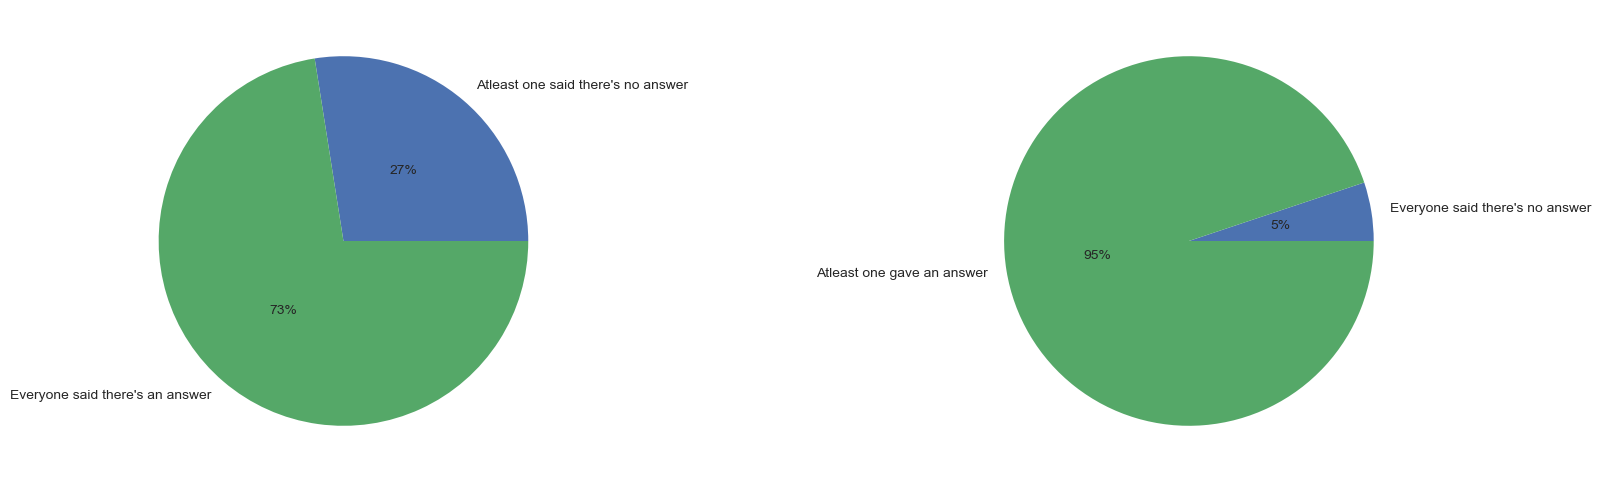

In [7]:
# Answer statistics
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))

atleast_one_no_ans = len(df[df['is_answer_absent'] != 0])
sizes1 = [atleast_one_no_ans, len(df) - atleast_one_no_ans]
labels1 = ['Atleast one said there\'s no answer', 'Everyone said there\'s an answer']
ax[0].pie(sizes1, labels = labels1, autopct = '%1.0f%%', pctdistance = 0.5, labeldistance = 1.1)

all_no_ans = len(df[df['is_answer_absent'] == 1])
sizes2 = [all_no_ans, len(df) - all_no_ans]
labels2 = ['Everyone said there\'s no answer', 'Atleast one gave an answer']
ax[1].pie(sizes2, labels = labels2, autopct = '%1.0f%%', pctdistance = 0.5, labeldistance = 1.1)

plt.show()

In 22% of the cases where some said there is no answer and some crowdworkers provided an answer, it might be possible that some crowdworkers did not find an answer. In those cases, we can ignore the 'None' answer.

In [8]:
# Precentage of questions that have validated answers
100*df['validated_answers'].isnull().sum()/len(df)

56.02209315567703

In [9]:
# Story, question, answer example
# random.seed(0)
idx = random.randint(0, len(df))
with open(df['story_id'][idx]) as f:
    story = f.read()
    
question = df['question'][idx]
answers = re.split(',|\|', df['answer_char_ranges'][idx])

print("Story ({} words):".format(len(story)))
print(story)
print("\nQuestion ({} words): {}".format(len(question), question))

for ans_range in answers:
    if ans_range == 'None':
        print("Answer: None")
    else:
        indices = ans_range.split(':')
        print("Answer: ", story[int(indices[0]):int(indices[1])])

Story (4459 words):
Palm Beach, Florida (CNN) -- For years, Army veteran Roy Foster's motto has been "No man left behind." This month, he's broadened it to include women.

In November, Foster was recognized at "CNN Heroes: An All-Star Tribute" as a Top 10 CNN Hero of 2009 for his efforts to help male veterans struggling with homelessness and addiction. His nonprofit, Faith*Hope*Love*Charity, has provided food, housing, counseling, employment and medical services to more than 1,100 veterans.

"I was somewhat overwhelmed at the tribute. To be a part of something that you love doing -- to be honored in doing it was, you know, strange," recalled Foster, 54. "But then to be showcased internationally was tremendous. And it's still reaping benefits today."

Among those benefits is Foster's recent opening of the First Stop Resource Center and Housing Program in Palm Beach, Florida. The center and program widen the scope of support services his organization has been offering through its origina

In [10]:
# Word counts in questions
cv = CountVectorizer(stop_words = ['the', 'is', 'was', 'of', 'to', 'in'])
dtm = cv.fit_transform(df['question']).toarray()

word_counts = dtm.sum(axis = 0)

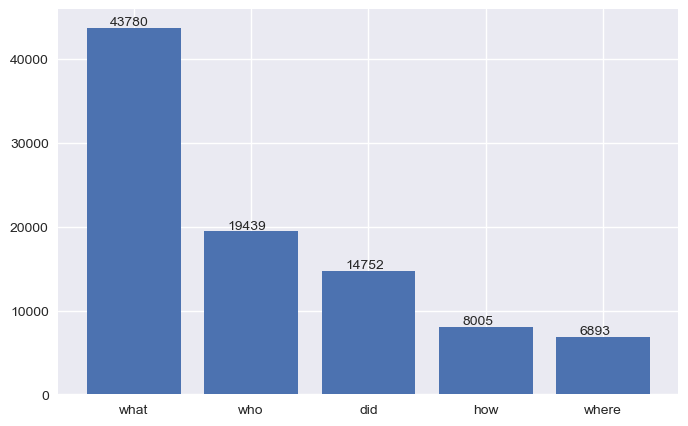

In [13]:
# Plotting top 5 words
fig, ax = plt.subplots(figsize = (8, 5))

sorted_idx = np.argsort(word_counts)[::-1]
vocab = np.array(cv.get_feature_names_out())

top_words_idx = sorted_idx[:5]
plt.bar(x = vocab[top_words_idx], height = word_counts[top_words_idx])

for i in range(len(top_words_idx)):
    plt.text(x = i - 0.2, y = word_counts[top_words_idx[i]] + 300, s = word_counts[top_words_idx[i]])

plt.show()

From this chart, we can see the types of questions in this dataset. Majority are 'What' questions followed by 'Who'.

In [14]:
# Removing the path and keeping just the file name in story_id
df['story_id'] = df['story_id'].apply(lambda x: x.split('/')[-1].split('.')[0])

In [15]:
# Saving the formatted data
df.to_csv('../data/newsqa-data-formatted.csv', index = False)